# Walking Mode Feature Analysis

This notebook analyzes the EMG features used for the walking mode classification. The goal is to maximize the explainability of the model's high accuracy (98%) by visualizing the separability of the classes in the feature space.

**Modes:**
*   Sitting
*   Level Walking
*   Ramp Ascent
*   Ramp Descent

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Add src to path to allow importing lib modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.data_loader import Enabl3sDataLoader
from lib.preprocess import EMGPreprocessor
from lib.dataset import MultiModeDataset

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [2]:
# Constants
MODE_NAMES = {
    0: "Sitting",
    1: "Level Walking",
    2: "Ramp Ascent",
    3: "Ramp Descent",
}

EMG_CHANNELS = ['TA', 'MG', 'RF']
TARGET_FS = 250
WINDOW_SIZE_MS = 2000
STEP_SIZE_MS = 100

## 1. Feature Extraction Logic

We use the same feature extraction logic as in the training script: **Mean Absolute Value (MAV)**, **Root Mean Square (RMS)**, and **Waveform Length (WL)** for each channel.

In [3]:
def extract_features_from_window(window, channels):
    """Extract MAV, RMS, and WL features from each EMG channel."""
    features = {}
    for i, ch in enumerate(channels):
        channel_data = window[:, i]
        features[f'{ch}_MAV'] = np.mean(np.abs(channel_data))
        features[f'{ch}_RMS'] = np.sqrt(np.mean(channel_data ** 2))
        features[f'{ch}_WL'] = np.sum(np.abs(np.diff(channel_data)))
    return features

def create_feature_dataset(df, emg_channels, window_size_ms, step_size_ms, target_fs):
    """Create windowed dataset and return a DataFrame with features."""
    dataset = MultiModeDataset(
        df=df,
        feature_cols=emg_channels,
        label_col='Mode',
        window_size_ms=window_size_ms,
        step_size_ms=step_size_ms,
        fs=target_fs
    )
    
    print(f"Extracting features from {len(dataset)} windows...")
    data_list = []
    
    for i, (window, label) in enumerate(dataset):
        feats = extract_features_from_window(window, emg_channels)
        feats['Mode'] = int(label)
        feats['Mode_Name'] = MODE_NAMES.get(int(label), 'Unknown')
        data_list.append(feats)
        
    return pd.DataFrame(data_list)

## 2. Load and Preprocess Data

We load data for subject **AB156**.

In [6]:
def load_and_preprocess(subject, data_root="../../data"):
    print(f"Loading {subject}...")
    loader = Enabl3sDataLoader(data_root, subject, target_fs=TARGET_FS)
    raw_dir = os.path.join(data_root, subject, 'Raw')
    
    # List all raw circuits
    if not os.path.exists(raw_dir):
        print(f"Path not found: {raw_dir}")
        return pd.DataFrame()
        
    circuit_files = [f for f in os.listdir(raw_dir) if f.endswith('_raw.csv')]
    circuits_to_load = range(1, len(circuit_files) + 1)
    
    # Load
    load_cols = EMG_CHANNELS + ['Mode']
    df = loader.load_dataset_batch(circuits_to_load, load_cols)
    
    # Filter modes
    df = df[df['Mode'].isin(MODE_NAMES.keys())]
    
    # Preprocess (Filter + Rectify)
    if not df.empty:
        preprocessor = EMGPreprocessor()
        df[EMG_CHANNELS] = preprocessor.apply_filter(df[EMG_CHANNELS].values)
        df[EMG_CHANNELS] = preprocessor.rectify(df[EMG_CHANNELS].values)
        
    return df

In [7]:
# Load data
subject_data = load_and_preprocess("AB156")
print(f"Loaded {len(subject_data)} samples.")

# Extract features
if not subject_data.empty:
    feature_df = create_feature_dataset(subject_data, EMG_CHANNELS, WINDOW_SIZE_MS, STEP_SIZE_MS, TARGET_FS)
    print(f"Feature DataFrame shape: {feature_df.shape}")
    display(feature_df.head())
else:
    print("No data loaded. Please check the data path.")

14:25:26 - INFO - Starting batch load: Circuits 1 to 50...


Loading AB156...


14:25:27 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 57.07%
14:25:28 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.32%
14:25:28 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.05%
14:25:29 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 40.71%
14:25:29 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 26.70%
14:25:30 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 30.75%
14:25:30 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.10%
14:25:31 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 30.31%
14:25:31 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 52.06%
14:25:32 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). 

Loaded 220700 samples.
Extracting features from 5078 windows...
Feature DataFrame shape: (5078, 11)


,TA_MAV,TA_RMS,TA_WL,MG_MAV,MG_RMS,MG_WL,RF_MAV,RF_RMS,RF_WL,Mode,Mode_Name
0,0.021468,0.024051,9.030083,0.015440,0.018300,6.735107,0.008009,0.009100,3.204522,0,Sitting
1,0.021429,0.023954,9.058609,0.015567,0.018345,6.696702,0.007922,0.008864,3.186098,0,Sitting
2,0.021582,0.024069,9.024248,0.015649,0.018447,6.741866,0.007992,0.008910,3.175185,0,Sitting
3,0.021474,0.023961,9.005354,0.015492,0.018322,6.675468,0.007942,0.008848,3.139767,0,Sitting
4,0.021474,0.023993,9.101044,0.015343,0.018141,6.726878,0.007920,0.008823,3.120032,0,Sitting


## 3. Class Distribution

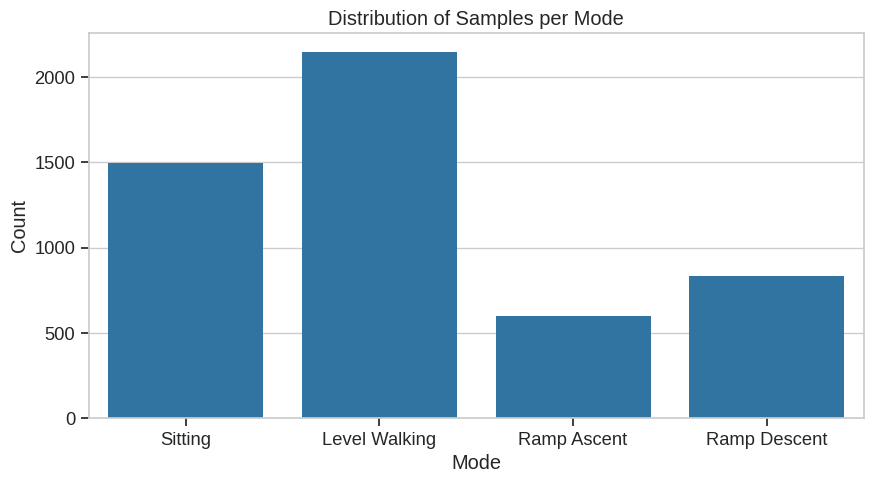

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(data=feature_df, x='Mode_Name', order=list(MODE_NAMES.values()))
plt.title("Distribution of Samples per Mode")
plt.xlabel("Mode")
plt.ylabel("Count")
plt.show()

## 4. Feature Distributions by Class

Here we visualize the distribution of each feature (MAV, RMS, WL) for each Muscle (TA, MG, RF). Distinct distributions imply good separability.

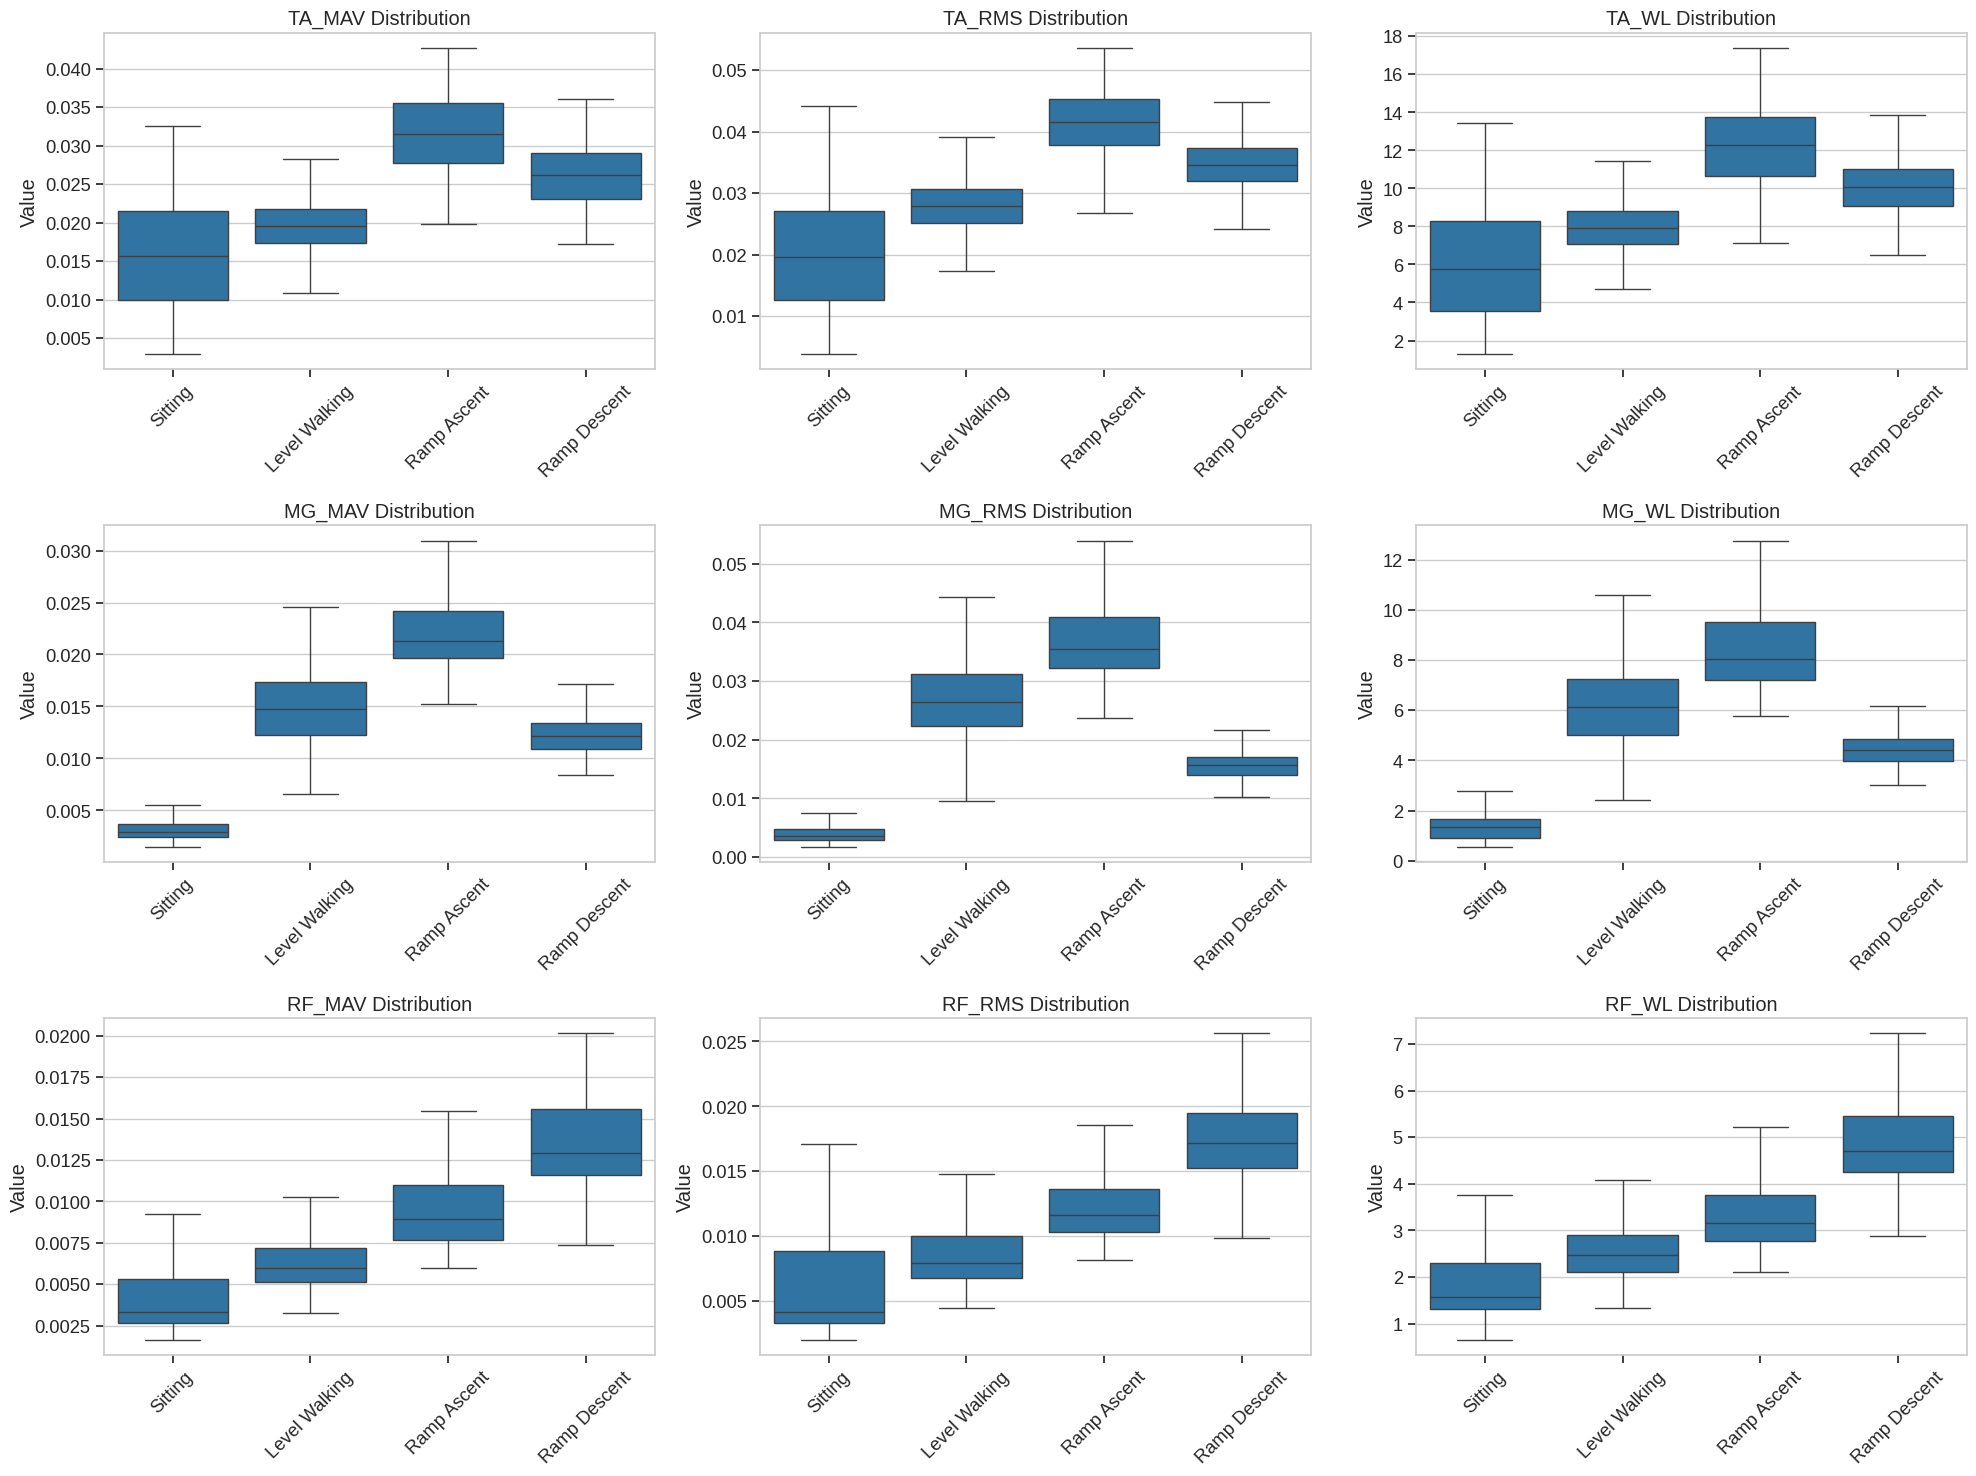

In [9]:
feature_cols = [c for c in feature_df.columns if c not in ['Mode', 'Mode_Name']]

plt.figure(figsize=(20, 15))
for i, col in enumerate(feature_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=feature_df, x='Mode_Name', y=col, showfliers=False, order=list(MODE_NAMES.values()))
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)
    plt.ylabel("Value")
    plt.xlabel("")
    
plt.tight_layout()
plt.show()

### Observation
As we can see, **Sitting** typically has very low feature values (muscle inactivity). **Walking** and **Ramp** modes show increased activity. Any separation between the boxes indicates that the feature is discriminative.

## 5. Dimensionality Reduction

We use PCA to project the 9-dimensional feature space (3 muscles * 3 features) into 2D to visualize global clusters.

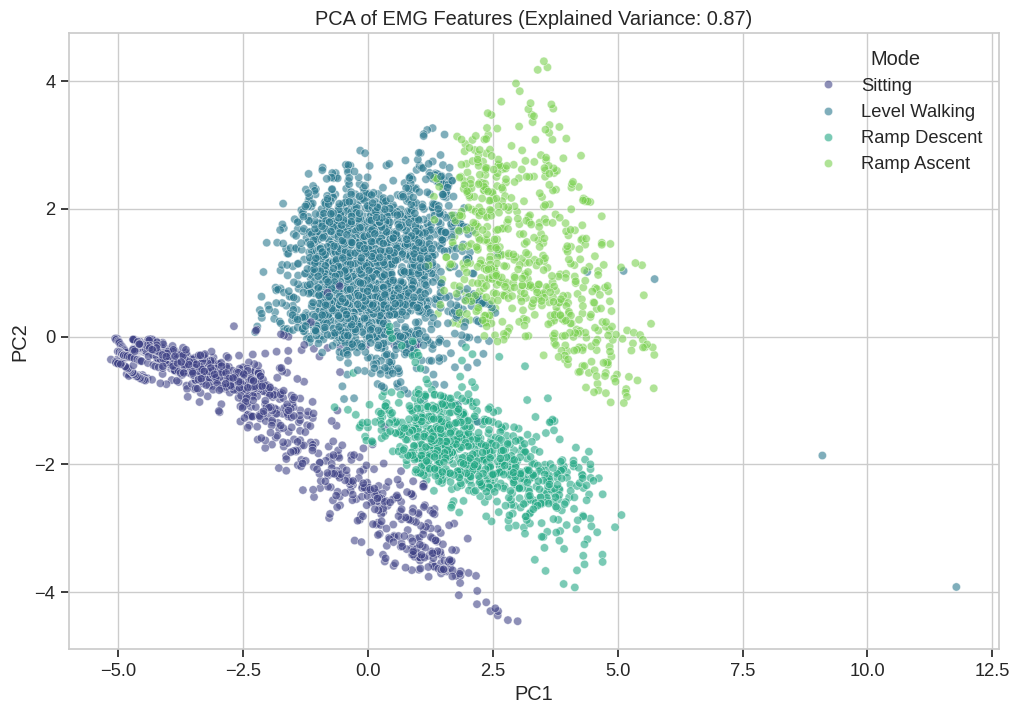

In [10]:
# Scale features
X = feature_df[feature_cols].values
y = feature_df['Mode_Name'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Mode'] = y

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Mode', alpha=0.6, palette='viridis')
plt.title(f"PCA of EMG Features (Explained Variance: {pca.explained_variance_ratio_.sum():.2f})")
plt.show()

## 6. Model Performance Verification

To confirm the separability, we train a simple Random Forest classifier (similar to the production model) and view the confusion matrix.

Classification Report:
               precision    recall  f1-score   support

Level Walking       0.99      0.99      0.99       645
  Ramp Ascent       0.97      0.98      0.98       181
 Ramp Descent       1.00      0.99      0.99       250
      Sitting       1.00      1.00      1.00       448

     accuracy                           0.99      1524
    macro avg       0.99      0.99      0.99      1524
 weighted avg       0.99      0.99      0.99      1524



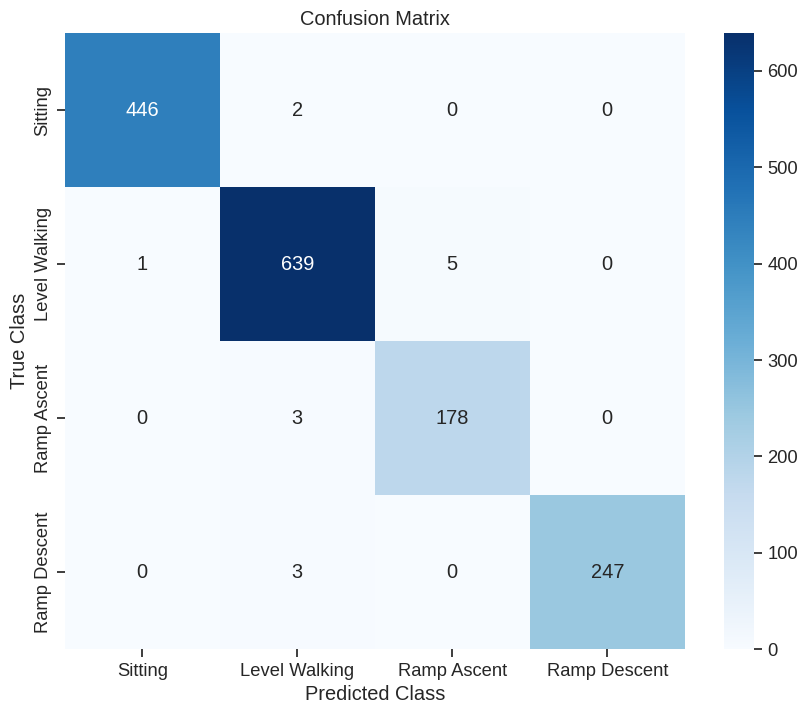

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=list(MODE_NAMES.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(MODE_NAMES.values()), 
            yticklabels=list(MODE_NAMES.values()))
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

## Conclusion

The analysis confirms why the model achieves such high accuracy:
1.  **Distinct Feature Ranges**: The boxplots show clear separation in feature distributions between resting (Sitting) and active modes.
2.  **Cluster Separation**: PCA visualization likely shows clusters for each mode, though overlap may exist between similar dynamic modes (Walking vs Ramps).
3.  **Classifier Validation**: The confusion matrix demonstrates minimal misclassification, validating the training script's reported performance.